# Computer-based exploration of Galton-Watson Processes

Let's assume we have a Galton-Watson Process with a known offspring distribution.

For example, consider a Negative Binomial Distribution with parameters $p$ and $r$.

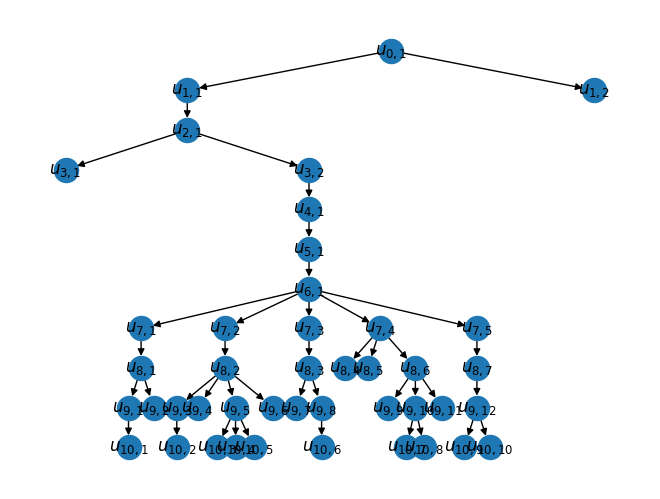

Population sizes by generation: [ 1  2  1  2  1  1  1  5  7 12 10]


In [1]:
# Import all helper functions used in the AMSI 2026 PGF material.
# In particular, this provides:
#   - GaltonWatsonTreeSimulation : simulates a Galton–Watson process as a tree
#   - hierarchy_pos              : computes node positions for tree-style plots
from AMSI_2026_PGF_tools import *

# Numerical and scientific computing
import numpy as np

# NetworkX is used to store the Galton–Watson tree as a directed graph
# (parents -> children)
import networkx as nx

# Matplotlib is used only for visualisation
import matplotlib.pyplot as plt


# -------------------------------------------------------------------
# Negative binomial offspring distribution
# -------------------------------------------------------------------
# We model the number of offspring of each individual using a
# negative binomial distribution.
#
# NumPy parameterisation:
#   np.random.negative_binomial(n, p)
#
# returns the number of *failures* before achieving n successes,
# where each trial has success probability p.
#
# In a Galton–Watson context, we simply interpret this integer as
# the number of offspring produced by an individual.
#
# Mean number of offspring:
#   E[K] = n (1 - p) / p
# -------------------------------------------------------------------


# Create a random number generator.
# Using default_rng() is preferred to the older np.random interface.
rng = np.random.default_rng()


# -------------------------------------------------------------------
# Negative binomial parameters
# -------------------------------------------------------------------
# n controls the dispersion (how variable the offspring numbers are).
# p controls the success probability in each Bernoulli trial.
#
# Note:
#   NumPy allows n to be non-integer, which is convenient for modelling
#   overdispersed offspring distributions.
# -------------------------------------------------------------------

n = 1.5          # "number of successes" (dispersion-like parameter)
p = 0.5          # success probability

# Uncomment the following line if you want *reproducible* simulations
# rng = np.random.default_rng(12345)


def NegBinOffspringDist():
    """
    Sample the number of offspring produced by a single individual.

    Each call returns an independent draw from a negative binomial
    distribution with parameters (n, p).
    """
    return rng.negative_binomial(n, p)


# -------------------------------------------------------------------
# Run one Galton–Watson tree simulation
# -------------------------------------------------------------------
# G     : a directed graph representing the realised Galton-Watson tree
# Xlist : Xlist[g] = population size in generation g
# -------------------------------------------------------------------

G, Xlist = GaltonWatsonTreeSimulation(NegBinOffspringDist, num_generations=10)


# -------------------------------------------------------------------
# Plot the resulting Galton–Watson tree
# -------------------------------------------------------------------
# hierarchy_pos computes positions so that:
#   - generation 0 is at the top
#   - later generations appear lower
#   - siblings are placed side-by-side
# -------------------------------------------------------------------

pos = hierarchy_pos(G)

# Draw the tree structure (nodes and directed edges)
nx.draw(G, pos=pos, arrows=True)


# -------------------------------------------------------------------
# Label nodes using mathematical notation
# -------------------------------------------------------------------
# Each node is named (g, j), representing the j-th individual
# in generation g.
#
# We convert this into a LaTeX-style label u_{g,j} for display.
# -------------------------------------------------------------------

labels = { (g, j): rf"$u_{{{g},{j}}}$" for (g, j) in G.nodes }

nx.draw_networkx_labels(G, pos, labels=labels)

plt.show()


# -------------------------------------------------------------------
# Display population sizes by generation
# -------------------------------------------------------------------
print("Population sizes by generation:", Xlist)

# Uncomment these lines for additional diagnostics
# print("Total individuals in tree:", G.number_of_nodes())
# print("Total parent->child edges:", G.number_of_edges())


Rerun the code above a few times and it should give various different results.




Next we're going to look at extinction probability  The code below runs many simulations, and estimates the extinction probability based on that.  By default it decides extinction has happened if $X_g=0$ by $g=10$.  Then it plots the PGF and the line $y=x$. Run this with various parameters.  Try making the mean larger than, smaller than, and close to $1$

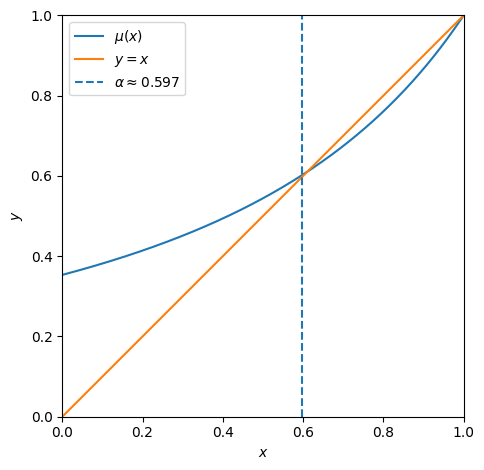

In [ ]:
# ------------------------------------------------------------
# Imports needed to run this cell on its own
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from AMSI_2026_PGF_tools import GaltonWatsonSimulation


# ------------------------------------------------------------
# Monte Carlo estimation of extinction probability
# ------------------------------------------------------------
# We estimate the probability of extinction by simulating
# many independent Galton–Watson processes and checking
# whether the population has died out by a fixed generation.
# ------------------------------------------------------------

def estimate_extinction_probability(r, p, OffspringDist, nsim=1000, max_generations=10):
    """
    Estimate the extinction probability of a Galton–Watson process
    using Monte Carlo simulation.

    Parameters
    ----------
    r, p : float
        Parameters of the offspring distribution (included here
        for clarity, though only OffspringDist is used directly).
    OffspringDist : callable
        A function returning the number of offspring of one individual.
    nsim : int
        Number of independent simulations.
    max_generations : int
        Maximum number of generations to simulate.

    Returns
    -------
    float
        Estimated probability that the process goes extinct.
    """
    extinct_count = 0

    for _ in range(nsim):
        # Run one Galton–Watson simulation
        Xlist = GaltonWatsonSimulation(
            OffspringDist,
            num_generations=max_generations
        )

        # If the population size at the final generation is zero,
        # we treat the process as extinct
        if Xlist[-1] == 0:
            extinct_count += 1

    return extinct_count / nsim


# ------------------------------------------------------------
# Probability generating function for the negative binomial
# ------------------------------------------------------------
# This is the PGF of a negative binomial(r, p) distribution:
#
#     mu(x) = E[x^K] = ( p / (1 - (1 - p) x) )^r
#
# In a Galton–Watson process, the extinction probability α
# satisfies the fixed-point equation:
#
#     α = mu(α)
# ------------------------------------------------------------

def nb_pgf(x, r, p):  # the PGF for the negative binomial distribution
    return (p / (1 - (1 - p) * x))**r


# ------------------------------------------------------------
# Parameters and offspring distribution
# ------------------------------------------------------------

r = 1.5
p = 0.5

# Random number generator for reproducibility if desired
rng = np.random.default_rng()

def NegBinOffspringDist():
    """
    Sample the number of offspring from a negative binomial
    distribution with parameters (r, p).
    """
    return rng.negative_binomial(r, p)


# ------------------------------------------------------------
# Estimate extinction probability via simulation
# ------------------------------------------------------------

alpha = estimate_extinction_probability(r, p, NegBinOffspringDist)
# print(alpha)


# ------------------------------------------------------------
# Plot mu(x) and y = x to visualise the fixed point
# ------------------------------------------------------------

x = np.linspace(0, 1, 1000)
mu_x = nb_pgf(x, r, p)

plt.plot(x, mu_x, label=r"$\mu(x)$")
plt.plot(x, x, label=r"$y=x$")

# Estimated extinction probability shown as a vertical line
plt.axvline(alpha, linestyle="--",
            label=rf"$\alpha \approx {alpha:.3f}$")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.tight_layout()
plt.show()


Next we'll look at the probability of extinction by generation $g$

The first plot shows how the extinction probability as predicted by theory $\alpha_{g+1} = \mu(\alpha_g)$ as well as from stochastic simulations compare as $g$ increases.

The second plot shows how the prediction looks as a "cobweb diagram" when plotted with the PGF.

Try seeing how fast convergence happens as $g$ increases when $\mu'(1)=1$.


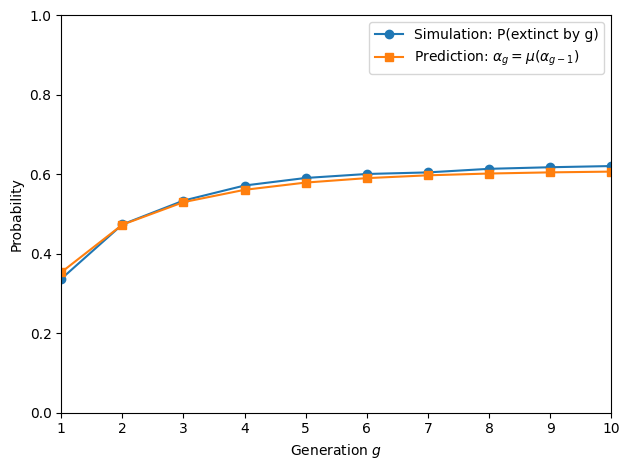

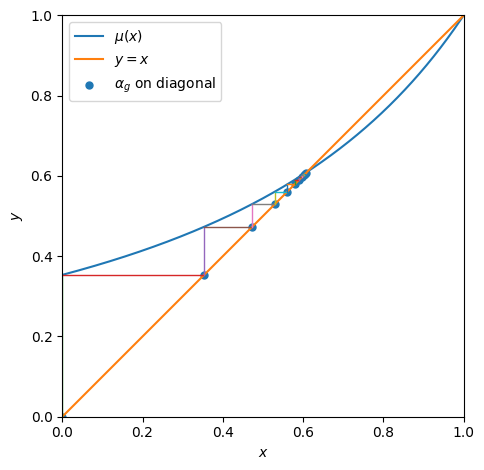

 g   sim P(X_g=0)     alpha_g
 1    0.337000        0.353553
 2    0.474000        0.473346
 3    0.534000        0.530138
 4    0.572000        0.561158
 5    0.591000        0.579402
 6    0.601000        0.590600
 7    0.605000        0.597652
 8    0.614000        0.602166
 9    0.618000        0.605085
10    0.621000        0.606986


In [ ]:
# ------------------------------------------------------------
# Imports needed to run this cell on its own
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Import the basic Galton–Watson simulator (population sizes only)
from AMSI_2026_PGF_tools.Galton_Watson import GaltonWatsonSimulation


# ------------------------------------------------------------
# Parameters for the Galton–Watson process
# ------------------------------------------------------------

r = 1.5          # negative binomial dispersion parameter
p = 0.5          # success probability
gmax = 10        # maximum generation to simulate
nsim = 1000      # number of Monte Carlo simulations

# Random number generator
rng = np.random.default_rng()


def OffspringDist():
    """
    Sample the number of offspring produced by one individual.

    Each call returns an independent draw from a negative binomial
    distribution with parameters (r, p).
    """
    return int(rng.negative_binomial(r, p))


def mu(x):
    """
    Probability generating function (PGF) of the offspring distribution.

    For a negative binomial(r, p) distribution,
        μ(x) = ( p / (1 - (1 - p) x) )^r
    """
    return (p / (1 - (1 - p) * x)) ** r


# ------------------------------------------------------------
# Simulation: estimate P(X_g = 0) for g = 1, ..., gmax
# ------------------------------------------------------------
# extinct_by_g[g] counts how many simulations first go extinct
# at generation g.
# ------------------------------------------------------------

extinct_by_g = np.zeros(gmax + 1, dtype=int)

for _ in range(nsim):
    # Run one Galton–Watson simulation
    # X[g] = population size in generation g
    X = GaltonWatsonSimulation(OffspringDist, num_generations=gmax)

    # Find the first generation at which extinction occurs
    for g in range(1, gmax + 1):
        if X[g] == 0:
            extinct_by_g[g] += 1
            break


# Cumulative probability:
#   P(X_g = 0) = probability that extinction has occurred
#   by generation g
sim_P_extinct_by_g = np.cumsum(extinct_by_g) / nsim


# ------------------------------------------------------------
# Theoretical prediction via PGF recursion
# ------------------------------------------------------------
# alpha_g = P(X_g = 0) satisfies
#
#   alpha_0 = 0
#   alpha_g = mu(alpha_{g-1})
# ------------------------------------------------------------

alpha = np.zeros(gmax + 1, dtype=float)
alpha[0] = 0.0

for g in range(1, gmax + 1):
    alpha[g] = mu(alpha[g - 1])


# ------------------------------------------------------------
# Plot: simulation vs theoretical prediction
# ------------------------------------------------------------

gvals = np.arange(1, gmax + 1)

plt.figure()
plt.plot(gvals, sim_P_extinct_by_g[1:], marker="o",
         label="Simulation: P(extinct by g)")
plt.plot(gvals, alpha[1:], marker="s",
         label=r"Prediction: $\alpha_g=\mu(\alpha_{g-1})$")

plt.xlim(1, gmax)
plt.ylim(0, 1)
plt.xlabel("Generation $g$")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# Cobweb diagram for the recursion alpha_{g} = mu(alpha_{g-1})
# ------------------------------------------------------------

x = np.linspace(0, 1, 1000)
mu_x = mu(x)

plt.figure()
plt.plot(x, mu_x, label=r"$\mu(x)$")
plt.plot(x, x, label=r"$y=x$")
plt.gca().set_aspect("equal", adjustable="box")

# Cobweb construction starting from alpha_0 = 0
a = alpha[0]

for g in range(1, gmax + 1):
    a_next = alpha[g]  # = mu(a)
    # Vertical step: from (a, a) to (a, mu(a))
    plt.plot([a, a], [a, a_next], linewidth=1)

    # Horizontal step: from (a, mu(a)) to (mu(a), mu(a))
    plt.plot([a, a_next], [a_next, a_next], linewidth=1)

    a = a_next


# Mark the points (alpha_g, alpha_g) on the diagonal
plt.scatter(alpha[:gmax + 1], alpha[:gmax + 1],
            s=25, label=r"$\alpha_g$ on diagonal")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# Numerical comparison table
# ------------------------------------------------------------

print(" g   sim P(X_g=0)     alpha_g")
for g in gvals:
    print(f"{g:2d}   {sim_P_extinct_by_g[g]: .6f}       {alpha[g]: .6f}")


Now we'll look at the size distribution at generation $g=5$.  This calculates $\Phi_g(e^{i\theta})$ and then uses Cauchy integrals (actually Fast Fourier Transforms) to find the coefficients.



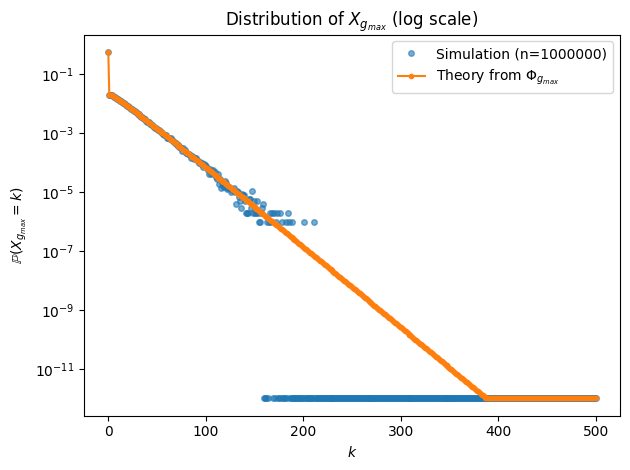

In [ ]:
# Import Galton–Watson simulation tools:
#   - GaltonWatsonSimulation : simulates population sizes by generation
#   - Phi_coefficients_real  : computes coefficients of the generating
#                             function Phi_g for X_g
from AMSI_2026_PGF_tools.Galton_Watson import GaltonWatsonSimulation, Phi_coefficients_real
                               
import numpy as np
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# Parameters
# ------------------------------------------------------------

r = 1.5          # negative binomial dispersion parameter
p = 0.5          # success probability
gmax = 5         # maximum generation (used for labels and plotting)
nsim = 1_000_000 # number of Monte Carlo simulations
g = 5            # generation at which we study the distribution of X_g

# Number of coefficients used when approximating the distribution
# from the probability generating function Phi_g
numCoefficients = 500

# Random number generator
rng = np.random.default_rng()


def OffspringDist():
    """
    Sample the number of offspring produced by one individual.

    Each call returns an independent draw from a negative binomial
    distribution with parameters r and p.
    """
    return int(rng.negative_binomial(r, p))


def mu(x):
    """
    Probability generating function mu of the offspring distribution.

    For a negative binomial distribution with parameters r and p,

        mu(x) = ( p / (1 - (1 - p) x) )^r
    """
    return (p / (1 - (1 - p) * x)) ** r


# ------------------------------------------------------------
# Theory: compute P(X_g = k) from coefficients of Phi_g
# ------------------------------------------------------------
# Phi_g(x) is the probability generating function of X_g.
# The coefficient of x^k in Phi_g(x) is P(X_g = k).
#
# Phi_coefficients_real returns the first numCoefficients
# coefficients of Phi_g.
# ------------------------------------------------------------

p_theory = np.asarray(
    Phi_coefficients_real(g, numCoefficients, mu),
    dtype=float
)  # length = numCoefficients


# ------------------------------------------------------------
# Simulation: sample X_g many times
# ------------------------------------------------------------
# We simulate the Galton–Watson process nsim times and record
# the population size X_g at generation g.
# ------------------------------------------------------------

Xg = np.zeros(nsim, dtype=int)

for i in range(nsim):
    # Run one Galton–Watson simulation
    # X = (X_0, X_1, ..., X_g)
    X = GaltonWatsonSimulation(OffspringDist, num_generations=g)
    Xg[i] = int(X[g])


# ------------------------------------------------------------
# Empirical probability mass function
# ------------------------------------------------------------
# We bin the simulated values of X_g.
#
# All values greater than or equal to numCoefficients are placed
# into a single "tail" bin at k = numCoefficients.
# ------------------------------------------------------------

counts = np.bincount(
    np.clip(Xg, 0, numCoefficients),
    minlength=numCoefficients + 1
)

p_emp = counts / nsim


# ------------------------------------------------------------
# Theory tail probability
# ------------------------------------------------------------
# The theoretical coefficients only sum over k = 0,...,numCoefficients-1.
# Any remaining probability mass is placed into the same tail bin.
# ------------------------------------------------------------

p_tail = max(0.0, 1.0 - p_theory.sum())
p_theory_with_tail = np.concatenate([p_theory, [p_tail]])


# Support of the distribution (including the tail bin)
k = np.arange(numCoefficients + 1)

# Small floor value for plotting on a logarithmic scale
eps = 1e-12


# ------------------------------------------------------------
# Plot: theory versus simulation on a logarithmic scale
# ------------------------------------------------------------

plt.figure()

# Simulation: plotted as points
plt.plot(
    k,
    np.maximum(p_emp, eps),
    linestyle="none",
    marker="o",
    markersize=4,
    alpha=0.6,
    label=f"Simulation (n={nsim})"
)

# Theory: plotted as a thin line with markers
plt.plot(
    k,
    np.maximum(p_theory_with_tail, eps),
    linestyle="-",
    marker=".",
    linewidth=1.5,
    label=r"Theory from $\Phi_{g_{max}}$"
)

plt.yscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$\mathbb{P}(X_{g_{max}}=k)$")
plt.title(r"Distribution of $X_{g_{max}}$ (log scale)")
plt.legend()
plt.tight_layout()
plt.show()
